In [1]:
import os
import pickle
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import L1L2

In [2]:
MODEL = "encoder-decoder-vector"

config = {    
    "EMBEDDING_SIZE": 16,
    
    "LR": 0.0005,
    "BATCH_SIZE": 32,
    "EPOCHS": 30,
}

In [3]:
RUN_WANDB = False

if(RUN_WANDB):
    import wandb
    from wandb.keras import WandbCallback
    from secrets import WANDB
    wandb.login(key=WANDB)

## **Load Data Function**

In [4]:
def get_data(fold):
    df = pd.read_csv(f'./data/fold_{fold}.csv')
    with open(f'./data/fold_{fold}.npy', mode='rb') as f:
        train_historical_series = np.load(f, allow_pickle=False)
        train_historical_covariates = np.load(f, allow_pickle=False) 
        train_future_covariates = np.load(f, allow_pickle=False)
        train_future_series = np.load(f, allow_pickle=False)
        # val arrays
        val_historical_series = np.load(f, allow_pickle=False)
        val_historical_covariates = np.load(f, allow_pickle=False) 
        val_future_covariates = np.load(f, allow_pickle=False)
        val_future_series = np.load(f, allow_pickle=False)
        # test arrays
        test_historical_series = np.load(f, allow_pickle=False)
        test_historical_covariates = np.load(f, allow_pickle=False) 
        test_future_covariates = np.load(f, allow_pickle=False)
        test_future_series = np.load(f, allow_pickle=False)
        test_dates = np.load(f, allow_pickle=True)
        # data info
        data_features = np.load(f, allow_pickle=False)
    return (
        (train_historical_series,train_historical_covariates,train_future_covariates),
        train_future_series, 
        (val_historical_series,val_historical_covariates,val_future_covariates),
        val_future_series, 
        (test_historical_series,test_historical_covariates,test_future_covariates), 
        test_future_series,
        test_dates,
        data_features,
        df
    )

X_train, y_train, X_val, y_val, X_test, y_test, test_dates, data_features, df = get_data(2)
df

,datetime,level
0,2005-12-31 12:00:00,60.0
1,2005-12-31 13:00:00,43.0
2,2005-12-31 14:00:00,23.0
3,2005-12-31 15:00:00,1.0
4,2005-12-31 16:00:00,-12.0
...,...,...
52591,2011-12-31 19:00:00,0.0
52592,2011-12-31 20:00:00,-2.0
52593,2011-12-31 21:00:00,2.0
52594,2011-12-31 22:00:00,9.0


In [5]:
X_train[0].shape, X_train[1].shape, X_train[2].shape

((43734, 72, 1), (43734, 72, 4), (43734, 24, 4))

## **Model Functions**

In [6]:
def simple_encoder_decoder(historical_series_shape, historical_covariates_shape, future_covariates_shape):
    historical_series = tf.keras.layers.Input(shape=historical_series_shape)
    historical_covariates = tf.keras.layers.Input(shape=historical_covariates_shape)
    future_covariates = tf.keras.layers.Input(shape=future_covariates_shape)
    
    historicals = tf.keras.layers.Concatenate()([historical_series, historical_covariates])
    embeddings = tf.keras.layers.LSTM(config["EMBEDDING_SIZE"], 
                                      return_sequences=True, 
                                      return_state=False, 
                                      recurrent_initializer='glorot_uniform', 
                                      activity_regularizer=L1L2(l1=0.000001, l2=0.000001))(historicals)
    embeddings = tf.keras.layers.LSTM(config["EMBEDDING_SIZE"], 
                                      return_sequences=False, 
                                      return_state=False, 
                                      recurrent_initializer='glorot_uniform', 
                                      activity_regularizer=L1L2(l1=0.000001, l2=0.000001))(embeddings)
    
    embeddings = tf.keras.layers.RepeatVector(future_covariates_shape[0])(embeddings)
    embeddings = tf.keras.layers.Concatenate(axis=-1)([future_covariates, embeddings])
    decoder = tf.keras.layers.LSTM(config["EMBEDDING_SIZE"],
                                   return_sequences=True,
                                   return_state=False,
                                   recurrent_initializer='glorot_uniform', 
                                   activity_regularizer=L1L2(l1=0.000001, l2=0.000001))(embeddings)
    
    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder)
    outputs = tf.squeeze(outputs, axis=-1)
    model = tf.keras.models.Model(inputs=[historical_series, historical_covariates, future_covariates], outputs=outputs)
    model.compile(loss="mse", metrics=["mae"], optimizer=tf.keras.optimizers.Adam(learning_rate=config["LR"]))
    return model

model = simple_encoder_decoder(X_train[0].shape[1:], X_train[1].shape[1:], X_train[2].shape[1:])
model.summary()

Metal device set to: Apple M1 Pro


2022-12-14 15:18:38.816651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 15:18:38.816986: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 72, 4)]      0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 72, 5)        0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 72, 16)       1408        ['concatenate[0][0]']        

In [7]:
    
#     decoder_output = tf.keras.layers.Dense(1)
#     all_outputs = []
#     states = [hidden, cell]
#         x, hidden_state, cell_state = decoder(last_value, initial_state=states)
#         states=[hidden_state, cell_state]
#         x = tf.keras.layers.Dropout(0.2)(x)
#         x = decoder_output(x)
#         last_value = x
#         all_outputs.append(x)
#     outputs = tf.keras.layers.Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
#     model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
#     model.compile(loss="mse", metrics=["mae"], optimizer=tf.keras.optimizers.Adam(learning_rate=config["LR"]))
#     return model


In [8]:
reducer = tf.keras.callbacks.ReduceLROnPlateau(monior='val_loss', factor=0.1, patience=2, mode='min', cooldown=1)
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min', restore_best_weights=True)
if(RUN_WANDB):
    callbacks = [reducer, stopper, WandbCallback()]
else:
    callbacks = [reducer, stopper]

model.fit(X_train, y_train,
          batch_size=config["BATCH_SIZE"],
          epochs=config["EPOCHS"], 
          callbacks=callbacks,
          validation_data=(X_val, y_val),
          validation_batch_size=config["BATCH_SIZE"],
          shuffle=True)

Epoch 1/30


2022-12-14 15:18:40.393644: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-14 15:18:45.394514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 15:18:45.989454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 15:18:46.348817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 15:18:46.846101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 15:18:47.665000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 15:18:48.043100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

1367/1367 [==============================] - ETA: 0s - loss: 0.4858 - mae: 0.5620

2022-12-14 15:21:16.529427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 15:21:16.760791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 15:21:17.070891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 15:21:17.428277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1367/1367 [==============================] - 174s 121ms/step - loss: 0.4858 - mae: 0.5620 - val_loss: 0.2698 - val_mae: 0.4064 - lr: 5.0000e-04
Epoch 2/30
1367/1367 [==============================] - 159s 116ms/step - loss: 0.2301 - mae: 0.3628 - val_loss: 0.1360 - val_mae: 0.2819 - lr: 5.0000e-04
Epoch 3/30
1367/1367 [==============================] - 179s 131ms/step - loss: 0.1707 - mae: 0.3076 - val_loss: 0.1156 - val_mae: 0.2599 - lr: 5.0000e-04
Epoch 4/30
1367/1367 [==============================] - 156s 114ms/step - loss: 0.1446 - mae: 0.2823 - val_loss: 0.1015 - val_mae: 0.2440 - lr: 5.0000e-04
Epoch 5/30
1367/1367 [==============================] - 125s 92ms/step - loss: 0.1857 - mae: 0.3230 - val_loss: 0.1286 - val_mae: 0.2758 - lr: 5.0000e-04
Epoch 6/30
1367/1367 [==============================] - 118s 86ms/step - loss: 0.1622 - mae: 0.3019 - val_loss: 0.1140 - val_mae: 0.2597 - lr: 5.0000e-04
Epoch 7/30
1367/1367 [==============================] - 102s 75ms/step - loss: 0.13

In [9]:
model.evaluate(X_test, y_test)

271/271 [==============================] - 9s 33ms/step - loss: 0.1297 - mae: 0.2566


[0.12972557544708252, 0.25657451152801514]

In [10]:
predictions = model.predict(X_test)
predictions = (predictions * data_features[1]) + data_features[0]
actuals = (y_test * data_features[1]) + data_features[0]
predictions

2022-12-14 16:17:37.661329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 16:17:37.763120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 16:17:37.893046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 16:17:38.018150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 9s 28ms/step


array([[34.263702 , 34.427296 , 37.908237 , ..., 33.82692  , 32.36449  ,
        30.059898 ],
       [32.145054 , 34.43268  , 40.92261  , ..., 32.001507 , 29.255835 ,
        27.185352 ],
       [31.483603 , 36.41867  , 44.5597   , ..., 28.368845 , 25.821318 ,
        25.343784 ],
       ...,
       [19.10905  , 10.89114  ,  5.5569057, ..., 49.99858  , 56.48407  ,
        53.612312 ],
       [ 8.571518 ,  1.800106 ,  3.8886604, ..., 53.921608 , 51.203384 ,
        42.59918  ],
       [ 5.2106457,  2.9420795, 11.815298 , ..., 47.31079  , 39.69548  ,
        27.397259 ]], dtype=float32)

In [11]:
predictions.shape, actuals.shape

((8670, 24), (8670, 24))

10.423805592136429


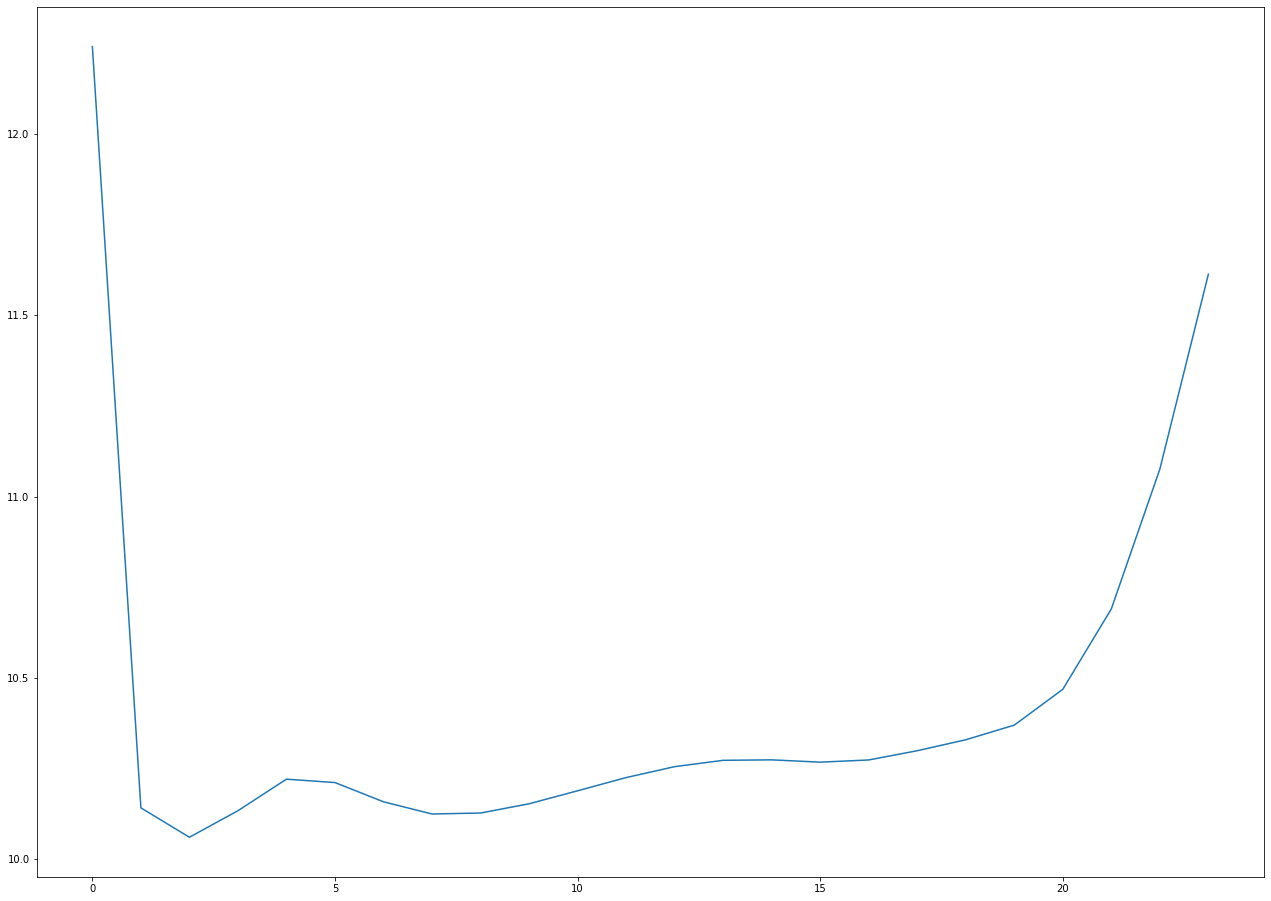

In [13]:
errors = np.sqrt(np.mean(np.square(predictions - actuals), axis=0))
print(np.mean(errors))
_, ax = plt.subplots(figsize=(22,16))
ax.plot(np.arange(len(errors)), errors);